# Colorectal polyp segmentation #
The code below uses the CVC-ClinicDB public data set which consists of 612 images with corresponding segmentation masks. The dataset can be found here: https://www.kaggle.com/balraj98/cvcclinicdb?select=metadata.csv.

To run the code, put the original .tif files in the `/data/images` folder and the segmentation masks (ground truth) in the `/data/masks` folder.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import itertools as it
import scipy.spatial as sp
import scipy.spatial.distance

from scipy.spatial import cKDTree
from pathlib import Path
from time import time
from functools import reduce
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold, GroupKFold
from Losses import ComboLoss, dice_metric
from Split import StratifiedGroupKFold 
from PIL import Image
import utils

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from torchvision import transforms
import torchvision.transforms as tvtransforms

import albumentations as albu
from albumentations.pytorch.transforms import ToTensor

print('torch.cuda.is_available():', torch.cuda.is_available())

torch.cuda.is_available(): True


In [2]:
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

In [3]:
DATA_DIR         = Path(f'data/')
TRAIN_IMG_DIR    = DATA_DIR/'images'
TRAIN_MASK_DIR   = DATA_DIR/'masks'
RLE_DF_PATH      = 'rle.csv'
KFOLD_PATH       = 'rle_kfold.csv'
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 16
USE_SAMPLER      = False
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['background', 'adenomatous', 'hyperplastic']
ACTIVATION       = None 
DEVICE           = 'cuda'
PRETRAINED_PATH  = 'models/bst_model512_fold0_0.7811.bin'
PRETRAINED       = False
LEARNING_RATE    = 1e-3 #1e-3 or 1e-4 for aggressive training, 1e-5 for normal
EPOCHS           = 12
LOSS_FN          = 'mixed'
CRITERION        = ComboLoss(**{'weights':{'bce':1, 'dice':2, 'focal':4}})
USE_CRIT         = True
TRAIN_MODEL      = True
EVALUATE         = True
FOLD_COUNT       = 5
FOLD_ID          = 0
IMG_SIZE         = 512

In [4]:
# The public datasets have more than 2 colors (due to gradients around the edges). Convert those colors to either black or white
def map_binary(mask):
    (threshold, black_and_white) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return black_and_white

"""
black = 0 -> background
red = 111 -> adenomatous
green = 170 -> hyperplastic
white = 255 -> adenomatous
"""
colors = np.array([[0,0,0], [255,255,255], [254,50,49], [51,254,51]], np.uint8)
label_ids = [0,1,1,2]
color_mapping = {tuple(c): t for c, t in zip(colors.tolist(), label_ids)}

# Convert mask colors to the nearest color
def map_rgb(mask):
    mask = torch.from_numpy(mask)
    mask = mask.permute(2, 0, 1).contiguous()
    empty = torch.zeros((len(CLASSES), mask.shape[1], mask.shape[2]))
    for k, v in color_mapping.items():
        color_ids = torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2)
        idx = (mask == color_ids)
        validx = (idx.sum(0) == 3)
        empty[v] = empty[v] + validx.long()
        
    return empty.permute(1,2,0).numpy()
    
    
# img = cv2.imread('data/masks/uah/00000001_3.png')
# dim = (int(img.shape[0] / 4), int(img.shape[1] / 4))
# img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# x = map_rgb(img)
# print(x[1].numpy())

In [5]:
# for file in tqdm(list(TRAIN_MASK_DIR.glob('**/*.*'))):
#     source = str(file.parent).split(os.sep)[-1]
#     image_id = f'{source}/{file.stem}{file.suffix}'
#     img = cv2.imread(f'data/masks/{image_id}')
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     h,w,bpp = np.shape(img)

#     img = colors[cKDTree(colors).query(img, k=1, workers=-1)[1]]

#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     cv2.imwrite(f'data/masks/{source}/{file.stem}_corrected{file.suffix}', img)

In [6]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.imshow(img.permute(1,2,0).numpy())

def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()

In [7]:
# data = {}
# image_ids = []
# image_classes = []

# for file in tqdm(list(TRAIN_MASK_DIR.glob('**/*.*'))):
#     source = str(file.parent).split(os.sep)[-1]
#     image_id = f'{source}/{file.stem}{file.suffix}'
#     img = cv2.imread(f'data/masks/{image_id}', 0)
#     class_ids = np.unique(nearest_color(img), return_counts=True)

#     if (len(class_ids[1]) == 2):
#         image_classes.append(1)
#     else:
#         if (class_ids[1][1] > class_ids[1][2]):
#             image_classes.append(1)
#         else:
#             image_classes.append(2)
    
#     image_ids.append(image_id)

# data['ImageId'] = image_ids
# data['ClassId'] = image_classes
# rle_df = pd.DataFrame(data, columns=['ImageId', 'ClassId'])
# rle_df.to_csv(RLE_DF_PATH, index=False)

In [7]:
combined_tmp_df  = pd.read_csv(RLE_DF_PATH, names=['ImageId', 'ClassId'], skiprows=1)
cvc_metadata_df  = pd.read_csv('cvc-metadata.csv')
etis_metadata_df = pd.read_csv('etis-metadata.csv')
uah_metadata_df  = pd.read_csv('uah-metadata.csv').drop(['ClassId'], axis=1)

dfs              = [combined_tmp_df, cvc_metadata_df, etis_metadata_df, uah_metadata_df]
RLE_DF           = reduce(lambda left, right: pd.merge(left, right, how='outer', on='ImageId'), dfs)

RLE_DF['sequence_id_tmp'] = RLE_DF['sequence_id_x'].combine_first(RLE_DF['sequence_id_y'])
RLE_DF['sequence'] = RLE_DF['sequence_id'].combine_first(RLE_DF['sequence_id_tmp'])
RLE_DF = RLE_DF.drop(columns=['sequence_id_x', 'sequence_id_y', 'sequence_id_tmp', 'sequence_id'])

RLE_DF['kfold'] = -1

gkf = GroupKFold(n_splits=FOLD_COUNT)

for fold, (train_index, test_index) in enumerate(gkf.split(RLE_DF.ImageId, RLE_DF.ClassId, RLE_DF.sequence)):
    RLE_DF.loc[test_index, 'kfold'] = fold
    
RLE_DF.to_csv(KFOLD_PATH, index=False)

RLE_DF.head()

,ImageId,ClassId,sequence,kfold
0,cvc/1.tif,1,cvc/1,1
1,cvc/10.tif,1,cvc/1,1
2,cvc/100.tif,1,cvc/5,0
3,cvc/101.tif,1,cvc/5,0
4,cvc/102.tif,1,cvc/5,0


In [8]:
DF = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)

In [9]:
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):
        self.df             = rle_df
        self.image_base_dir = image_base_dir
        self.masks_base_dir = masks_base_dir
        self.image_ids      = rle_df.ImageId.values
        self.augmentation   = augmentation
        self.mapping = {(0,   0,   0  ): 0,
                        (254, 50,  49 ): 1,
                        (255, 255, 255): 1,
                        (51,  254,  51): 2}
        
    def mask_to_class_rgb(self, mask):
        mask = torch.from_numpy(np.array(mask))
        mask = torch.squeeze(mask)

        class_mask = mask
        class_mask = class_mask.permute(2, 0, 1).contiguous()
        h, w = class_mask.shape[1], class_mask.shape[2]
        mask_out = torch.empty(h, w, dtype=torch.long)

        for k in self.mapping:
            idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
            validx = (idx.sum(0) == 3)
            mask_out[validx] = torch.tensor(self.mapping[k], dtype=torch.long)
            
        return mask_out
        
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        
        fileparts = str(image_id).split(".")
        img_path  = os.path.join(str(self.image_base_dir), str(image_id)) 
        mask_path = os.path.join(str(self.masks_base_dir), f'{fileparts[0]}_corrected.{fileparts[1]}')
        img       = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        msk       = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
        
        img_new = img
        mask_new = msk
        
        if self.augmentation:
            image_np = np.array(img)
            mask_np = np.array(msk)
            augmented = self.augmentation(image=image_np, mask=mask_np)
            img_new = augmented['image']
            mask_new = augmented['mask']
            img_new = torch.from_numpy(img_new).float()
        else:
            img_new = torch.from_numpy(img_new).float
            
        img_new = img_new.permute(2, 0, 1).contiguous()
        norm = tvtransforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        img_new = norm(img_new)
        
        mask_new = self.mask_to_class_rgb(mask_new)
        mask_new = mask_new.long()        

        return {
            'image': img_new,
            'mask': mask_new
        }
        
    def __len__(self):
        return len(self.image_ids)

In [10]:
train_transformations = albu.Compose([
    albu.SmallestMaxSize(max_size=288),
    albu.CenterCrop(288, 288),
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.Rotate(),
#     albu.Normalize(),
#     ToTensor()
])

test_transformations = albu.Compose([
    albu.SmallestMaxSize(max_size=288),
    albu.CenterCrop(288, 288),
#     albu.Normalize(),
#     ToTensor()
])

In [11]:
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_transformations)
test_dataset = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, test_transformations)

In [12]:
image, mask = train_dataset[0]['image'], train_dataset[0]['mask']
image.shape, mask.shape

# print(mask.squeeze(0).permute(2,0,1).shape)

(torch.Size([3, 288, 288]), torch.Size([288, 288]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: cannot select an axis to squeeze out which has size not equal to one

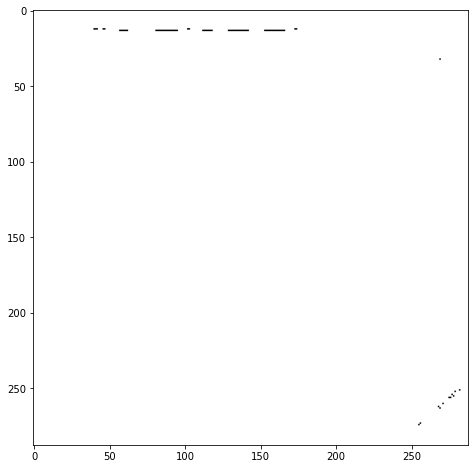

In [13]:
visualize(**train_dataset[2])

In [15]:
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=0, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(test_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=0)

In [16]:
images, masks = next(iter(train_dataloader))['image'], next(iter(train_dataloader))['mask']
images.shape, masks.shape

(torch.Size([8, 3, 288, 288]), torch.Size([8, 288, 288]))

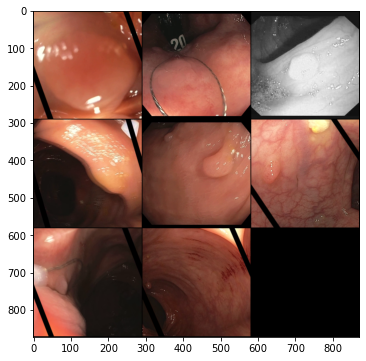

In [17]:
img_grid = torchvision.utils.make_grid(images[:9], nrow=3, normalize=True)
matplotlib_imshow(img_grid)

In [18]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    loss = ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    print(f'Dice loss: {loss}')
    return loss

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        print(f'Focal loss: {loss.mean()}')
        return loss.mean()

In [20]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        print(f'Mixed loss: {loss.mean()}')
        return loss.mean()

In [21]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [22]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [23]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [37]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [34]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        image = data['image']
        out  = model(image)
#         best = out.argmax(dim=1)
#         print(best.shape)
        mask = data['mask']
        loss = loss_fn(out, mask)
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

In [25]:
def acc_metric(input, target):
    inp = torch.where(input>0.5, torch.tensor(1, device='cuda'), torch.tensor(0, device='cuda'))
    acc = (inp.squeeze(1) == target).float().mean()
    return acc

In [26]:
def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice

In [27]:
def evaluate(valid_loader, model, device='cuda', metric=dice_metric):
    losses = AverageMeter()
    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            out   = model(data['image'])
            out   = torch.sigmoid(out)
            dice  = metric(out, data['mask']).cpu()
            losses.update(dice.mean().item(), valid_loader.batch_size)
            tk0.set_postfix(dice_score=losses.avg)
    return losses.avg

In [28]:
if PRETRAINED: 
    model.load_state_dict(torch.load(PRETRAINED_PATH))
    model.cuda()

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

In [30]:
# criterion = MixedLoss(10.0, 2.0) if not USE_CRIT else CRITERION 
criterion = nn.CrossEntropyLoss()
es = EarlyStopping(patience=10, mode='max')

In [31]:
criterion

CrossEntropyLoss()

In [35]:
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        dice = evaluate(val_dataloader, model, metric=metric)
        scheduler.step()
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")
        es(dice, model, model_path=f"/models/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.bin")
        best_model = f"../data/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
if EVALUATE:
    valid_score = evaluate(val_dataloader, model, metric=metric)
    print(f"Valid dice score: {valid_score}")

  0%|                                                                                           | 0/35 [00:00<?, ?it/s]


AssertionError: 

## Try the model on a video

In [ ]:
def center_crop(img, dim):
    width, height = img.shape[1], img.shape[0]

    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[miC:\Users\LeonCullens\Repos\ADAPT\docker-compose.ymld_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img

In [ ]:
# capture = cv2.VideoCapture('data/videos/17.mp4')
# _, frame = capture.read()
# H, W = frame.shape[:2]
# fourcc = cv2.VideoWriter_fourcc(*'DIVX')
# out = cv2.VideoWriter('data/videos/processed/17.mp4', fourcc, 30, (W,H))

# COLOR1 = [255, 0, 0]
# COLOR2 = [0, 0, 255]
# # success, frame = capture.read()

# model.to('cuda')
# model.eval()

# while capture.isOpened():
#     start_time = time()
#     _, frame = capture.read()
#     image = frame[...,::-1]
#     h, w = image.shape[:2]
#     read_cam_time = time()

#     X, pad_up, pad_left, h_new, w_new = utils.preprocessing(image, 1088, pad_value=0)
#     preproc_time = time()
#     with torch.no_grad():
#         mask = model(X.cuda())
#         mask = mask[..., pad_up: pad_up+h_new, pad_left: pad_left+w_new]
#         mask = F.interpolate(mask, size=(h,w), mode='bilinear', align_corners=True)
#         mask = F.softmax(mask, dim=1)
#         mask = mask[0,0,...].cpu().numpy()
#     predict_time = time()
        
#     image_alpha = utils.draw_transperency(image, mask, COLOR1, COLOR2)
#     draw_time = time()
    
#     read = read_cam_time-start_time
#     preproc = preproc_time-read_cam_time
#     pred = predict_time-preproc_time
#     draw = draw_time-predict_time
#     total = read + preproc + pred + draw
#     fps = 1 / total
#     print("read: %.3f [s]; preproc: %.3f [s]; pred: %.3f [s]; draw: %.3f [s]; total: %.3f [s]; fps: %.2f [Hz]" % 
#         (read, preproc, pred, draw, total, fps))
    
#     out.write(image_alpha[..., ::-1])
#     cv2.imshow('webcam', image_alpha[..., ::-1])

# capture.release()
# cv2.destroyAllWindows()